In [1]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512614 sha256=9620b2239392372704840cd0fe58452b1b9e042b006ce337e5360fc68b2ceae2
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448da

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2, TwoLocal,PauliTwoDesign
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from qiskit.primitives import Sampler
import time

In [3]:
breast_cancer= load_breast_cancer()

X, Y = breast_cancer['data'], breast_cancer['target']

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

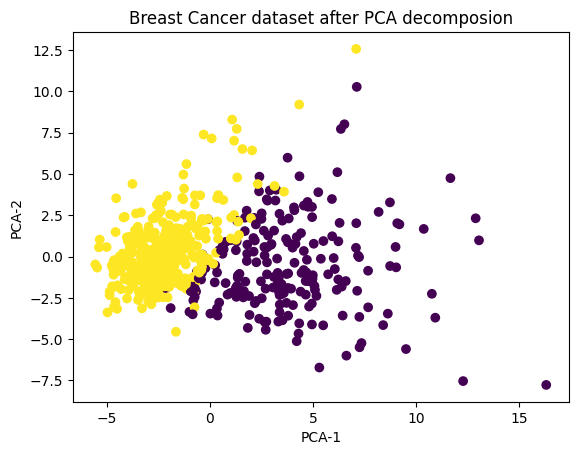

In [4]:
pca = PCA(n_components=2).fit_transform(X_scaled)

plt.scatter(pca[:,0], pca[:,1], c=Y)
plt.title('Breast Cancer dataset after PCA decomposion')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.show()

In [23]:
for i in range(2):
  rf = RandomForestClassifier(random_state=42)

  rf.fit(X_train, Y_train)

  feature_importances = rf.feature_importances_

  least_important_index = np.argmin(feature_importances)

  X_train = np.delete(X_train, least_important_index, axis=1)

  X_test = np.delete(X_test, least_important_index, axis=1)

In [24]:
MAXITR = 200
num_qubits = X.shape[1]//4
opt = COBYLA(maxiter=MAXITR)

In [25]:
featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

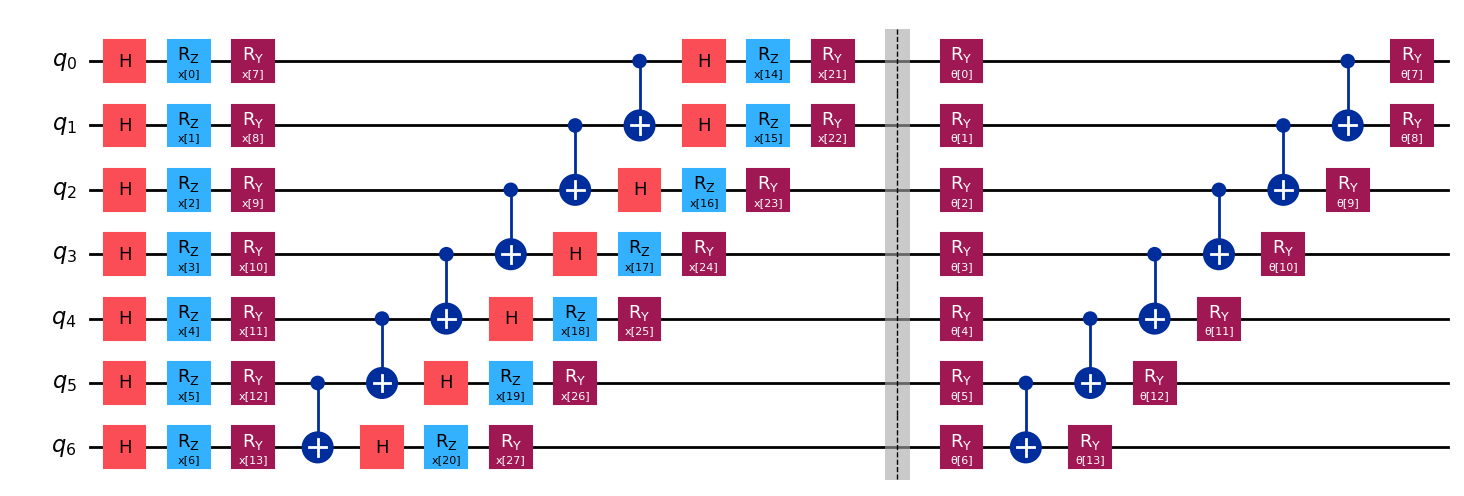

In [26]:
qc = QuantumCircuit(num_qubits)
qc.compose(featuremap, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output='mpl', style='iqx')

In [5]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
  clear_output(wait=True)
  objective_func_vals.append(obj_func_eval)
  plt.title("Objective function value against iteration")
  plt.xlabel("Iteration")
  plt.ylabel("Objective function value")
  plt.plot(range(len(objective_func_vals)), objective_func_vals)
  plt.show()

In [28]:
times = []
scores = []

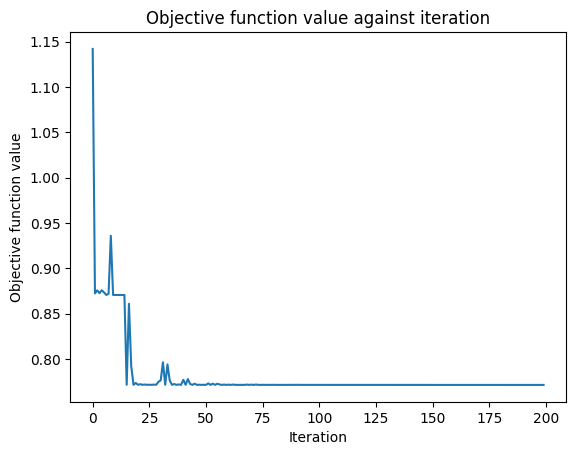

[0.7543859649122807]
[586.0183138847351]


In [29]:
vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
)

start = time.time()
vqc.fit(X_train, Y_train)
elapsed = time.time() - start
scores.append(vqc.score(X_test, Y_test))
print(scores)
times.append(elapsed)
print(times)


# **EfficientSU2/RealAmplitudes**

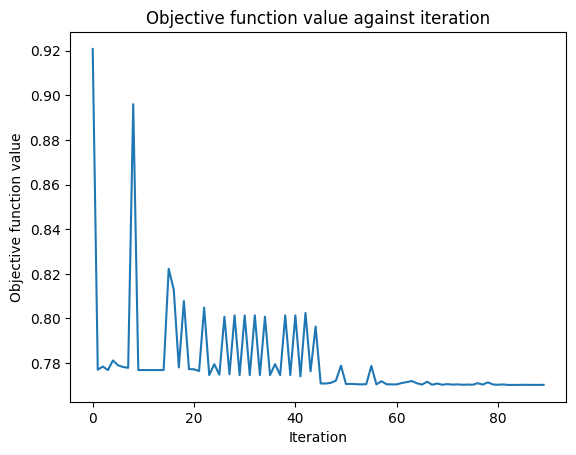

Precision:
 [0.7596952908587258, 0.7503586977271188, 0.7503586977271188, 0.7503586977271188, 0.7410218923376818, 0.7503586977271188, 0.7503586977271188, 0.7410218923376818, 0.7503586977271188, 0.7503586977271188]
Accuracy:
 [0.7631578947368421, 0.7543859649122807, 0.7543859649122807, 0.7543859649122807, 0.7456140350877193, 0.7543859649122807, 0.7543859649122807, 0.7456140350877193, 0.7543859649122807, 0.7543859649122807]
Recalls:
 [0.7364886996396987, 0.7248607926629544, 0.7248607926629544, 0.7248607926629544, 0.7132328856862102, 0.7248607926629544, 0.7248607926629544, 0.7132328856862102, 0.7248607926629544, 0.7248607926629544]
F1:
 [0.7598758801766321, 0.7501541014698909, 0.7501541014698909, 0.7501541014698909, 0.7403192800623596, 0.7501541014698909, 0.7501541014698909, 0.7403192800623596, 0.7501541014698909, 0.7501541014698909]
Time:
 [267.20170545578003, 244.90329957008362, 211.3423092365265, 214.2346305847168, 210.99168872833252, 209.49133348464966, 209.19023895263672, 211.68095993

In [32]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 90
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)
  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7596952908587258, 0.7503586977271188, 0.7503586977271188, 0.7503586977271188, 0.7410218923376818, 0.7503586977271188, 0.7503586977271188, 0.7410218923376818, 0.7503586977271188, 0.7503586977271188]
Accuracy:
 [0.7631578947368421, 0.7543859649122807, 0.7543859649122807, 0.7543859649122807, 0.7456140350877193, 0.7543859649122807, 0.7543859649122807, 0.7456140350877193, 0.7543859649122807, 0.7543859649122807]
Recalls:
 [0.7364886996396987, 0.7248607926629544, 0.7248607926629544, 0.7248607926629544, 0.7132328856862102, 0.7248607926629544, 0.7248607926629544, 0.7132328856862102, 0.7248607926629544, 0.7248607926629544]
F1:
 [0.7598758801766321, 0.7501541014698909, 0.7501541014698909, 0.7501541014698909, 0.7403192800623596, 0.7501541014698909, 0.7501541014698909, 0.7403192800623596, 0.7501541014698909, 0.7501541014698909]
Time:
 [267.20170545578003, 244.90329957008362, 211.3423092365265, 214.2346305847168, 210.99168872833252, 209.49133348464966, 209.19023895263672, 211.68095993995667, 208.28240418434143, 207.66985630989075]
Mean Precision: 0.7494249959623922±0.005027980222823808
Mean Accuracy: 0.7535087719298246±0.0047238287781881765
Mean Recall: 0.7248607926629544±0.0
Mean F1: 0.7491593150590588±0.005273181254491034
Mean Time: 219.49884264469148±19.02848505465434


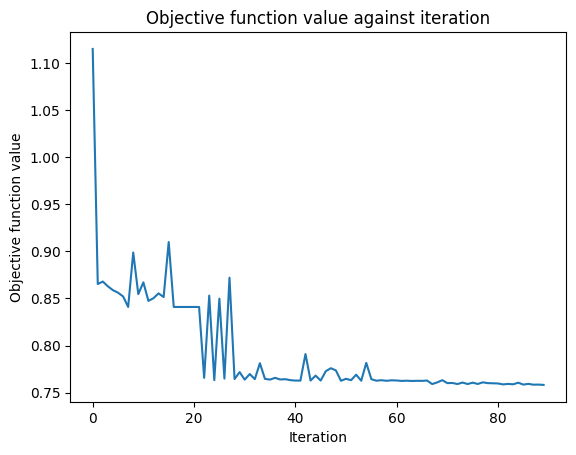

Precision:
 [0.751038651623447, 0.761392811296534, 0.751038651623447, 0.7316646045493481, 0.7778162511542014, 0.7686415054836108, 0.7596952908587258, 0.7222652218782251, 0.7316646045493481, 0.7689857555280607]
Accuracy:
 [0.7543859649122807, 0.7631578947368421, 0.7543859649122807, 0.7368421052631579, 0.7807017543859649, 0.7719298245614035, 0.7631578947368421, 0.7280701754385965, 0.7368421052631579, 0.7719298245614035]
Recalls:
 [0.7156894857517195, 0.7227317392728464, 0.7156894857517195, 0.701604978709466, 0.7551588601375696, 0.7435309531608254, 0.7364886996396987, 0.6899770717327218, 0.701604978709466, 0.738945299705208]
F1:
 [0.7463065558633425, 0.7543034055727555, 0.7463065558633425, 0.7303643724696357, 0.7776628520154001, 0.7680002370791845, 0.7598758801766321, 0.7202820416483714, 0.7303643724696357, 0.7663157894736841]
Time:
 [294.55783319473267, 300.4214036464691, 298.09030985832214, 298.6669602394104, 300.2122800350189, 298.2448673248291, 272.0325117111206, 237.73605608940125, 2

In [31]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 90
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)
  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.751038651623447, 0.761392811296534, 0.751038651623447, 0.7316646045493481, 0.7778162511542014, 0.7686415054836108, 0.7596952908587258, 0.7222652218782251, 0.7316646045493481, 0.7689857555280607]
Accuracy:
 [0.7543859649122807, 0.7631578947368421, 0.7543859649122807, 0.7368421052631579, 0.7807017543859649, 0.7719298245614035, 0.7631578947368421, 0.7280701754385965, 0.7368421052631579, 0.7719298245614035]
Recalls:
 [0.7156894857517195, 0.7227317392728464, 0.7156894857517195, 0.701604978709466, 0.7551588601375696, 0.7435309531608254, 0.7364886996396987, 0.6899770717327218, 0.701604978709466, 0.738945299705208]
F1:
 [0.7463065558633425, 0.7543034055727555, 0.7463065558633425, 0.7303643724696357, 0.7776628520154001, 0.7680002370791845, 0.7598758801766321, 0.7202820416483714, 0.7303643724696357, 0.7663157894736841]
Time:
 [294.55783319473267, 300.4214036464691, 298.09030985832214, 298.6669602394104, 300.2122800350189, 298.2448673248291, 272.0325117111206, 237.73605608940125, 236.2844409942627, 236.909588098526]
Mean Precision: 0.7524203348544947±0.01758030727391511
Mean Accuracy: 0.756140350877193±0.01655084409132737
Mean Recall: 0.738945299705208±0.0
Mean F1: 0.7499782062631984±0.017756830535296232
Mean Time: 277.3156251192093±27.55283512455736


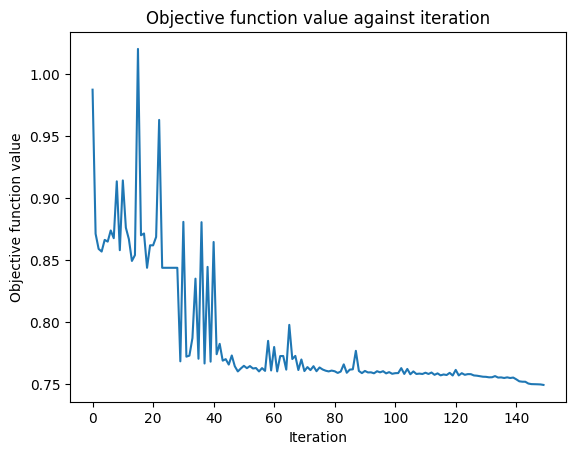

Precision:
 [0.7892767834288301, 0.7411442208462332, 0.7964087569350727, 0.7550834489875806, 0.751038651623447, 0.7690508322087269, 0.7722571099337929, 0.7789022187822497, 0.7411442208462332, 0.742010323063757]
Accuracy:
 [0.7894736842105263, 0.7456140350877193, 0.7982456140350878, 0.7543859649122807, 0.7543859649122807, 0.7719298245614035, 0.7719298245614035, 0.7807017543859649, 0.7456140350877193, 0.7456140350877193]
Recalls:
 [0.7530298067474614, 0.7086472322305928, 0.7692433671798231, 0.7065181788404848, 0.7156894857517195, 0.7481166066164429, 0.7297739927939731, 0.7459875532263347, 0.7086472322305928, 0.7040615787749753]
F1:
 [0.7825484764542936, 0.7383283615420249, 0.7940463255666991, 0.7415279652121758, 0.7463065558633425, 0.769491386334195, 0.7623234991656045, 0.7744210013293317, 0.7383283615420249, 0.736103657837404]
Time:
 [546.4760365486145, 515.4653055667877, 431.7582905292511, 430.9357821941376, 437.7894778251648, 444.0288281440735, 443.45965123176575, 448.07054352760315, 

In [33]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 150
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)
  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7892767834288301, 0.7411442208462332, 0.7964087569350727, 0.7550834489875806, 0.751038651623447, 0.7690508322087269, 0.7722571099337929, 0.7789022187822497, 0.7411442208462332, 0.742010323063757]
Accuracy:
 [0.7894736842105263, 0.7456140350877193, 0.7982456140350878, 0.7543859649122807, 0.7543859649122807, 0.7719298245614035, 0.7719298245614035, 0.7807017543859649, 0.7456140350877193, 0.7456140350877193]
Recalls:
 [0.7530298067474614, 0.7086472322305928, 0.7692433671798231, 0.7065181788404848, 0.7156894857517195, 0.7481166066164429, 0.7297739927939731, 0.7459875532263347, 0.7086472322305928, 0.7040615787749753]
F1:
 [0.7825484764542936, 0.7383283615420249, 0.7940463255666991, 0.7415279652121758, 0.7463065558633425, 0.769491386334195, 0.7623234991656045, 0.7744210013293317, 0.7383283615420249, 0.736103657837404]
Time:
 [546.4760365486145, 515.4653055667877, 431.7582905292511, 430.9357821941376, 437.7894778251648, 444.0288281440735, 443.45965123176575, 448.07054352760315, 518.7923889160156, 542.8531391620636]
Mean Precision: 0.7636316566655923±0.019440869426199492
Mean Accuracy: 0.7657894736842105±0.018421052631578956
Mean Recall: 0.7040615787749753±0.0
Mean F1: 0.7583425590847096±0.019956569821914273
Mean Time: 475.96294436454775±45.97188310229104


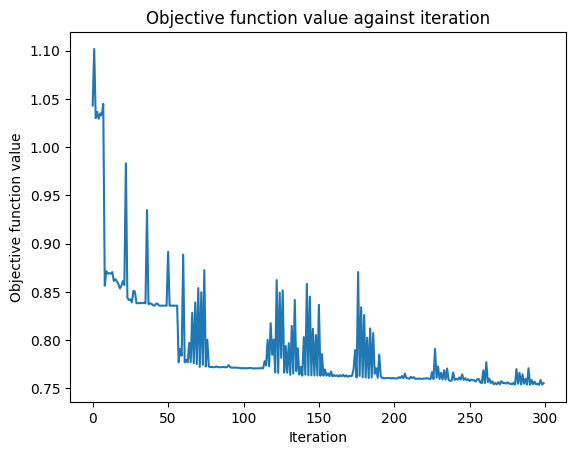

NameError: name 'precisions' is not defined

In [6]:
times = []
scores = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=["h", 'rz', "ry"])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

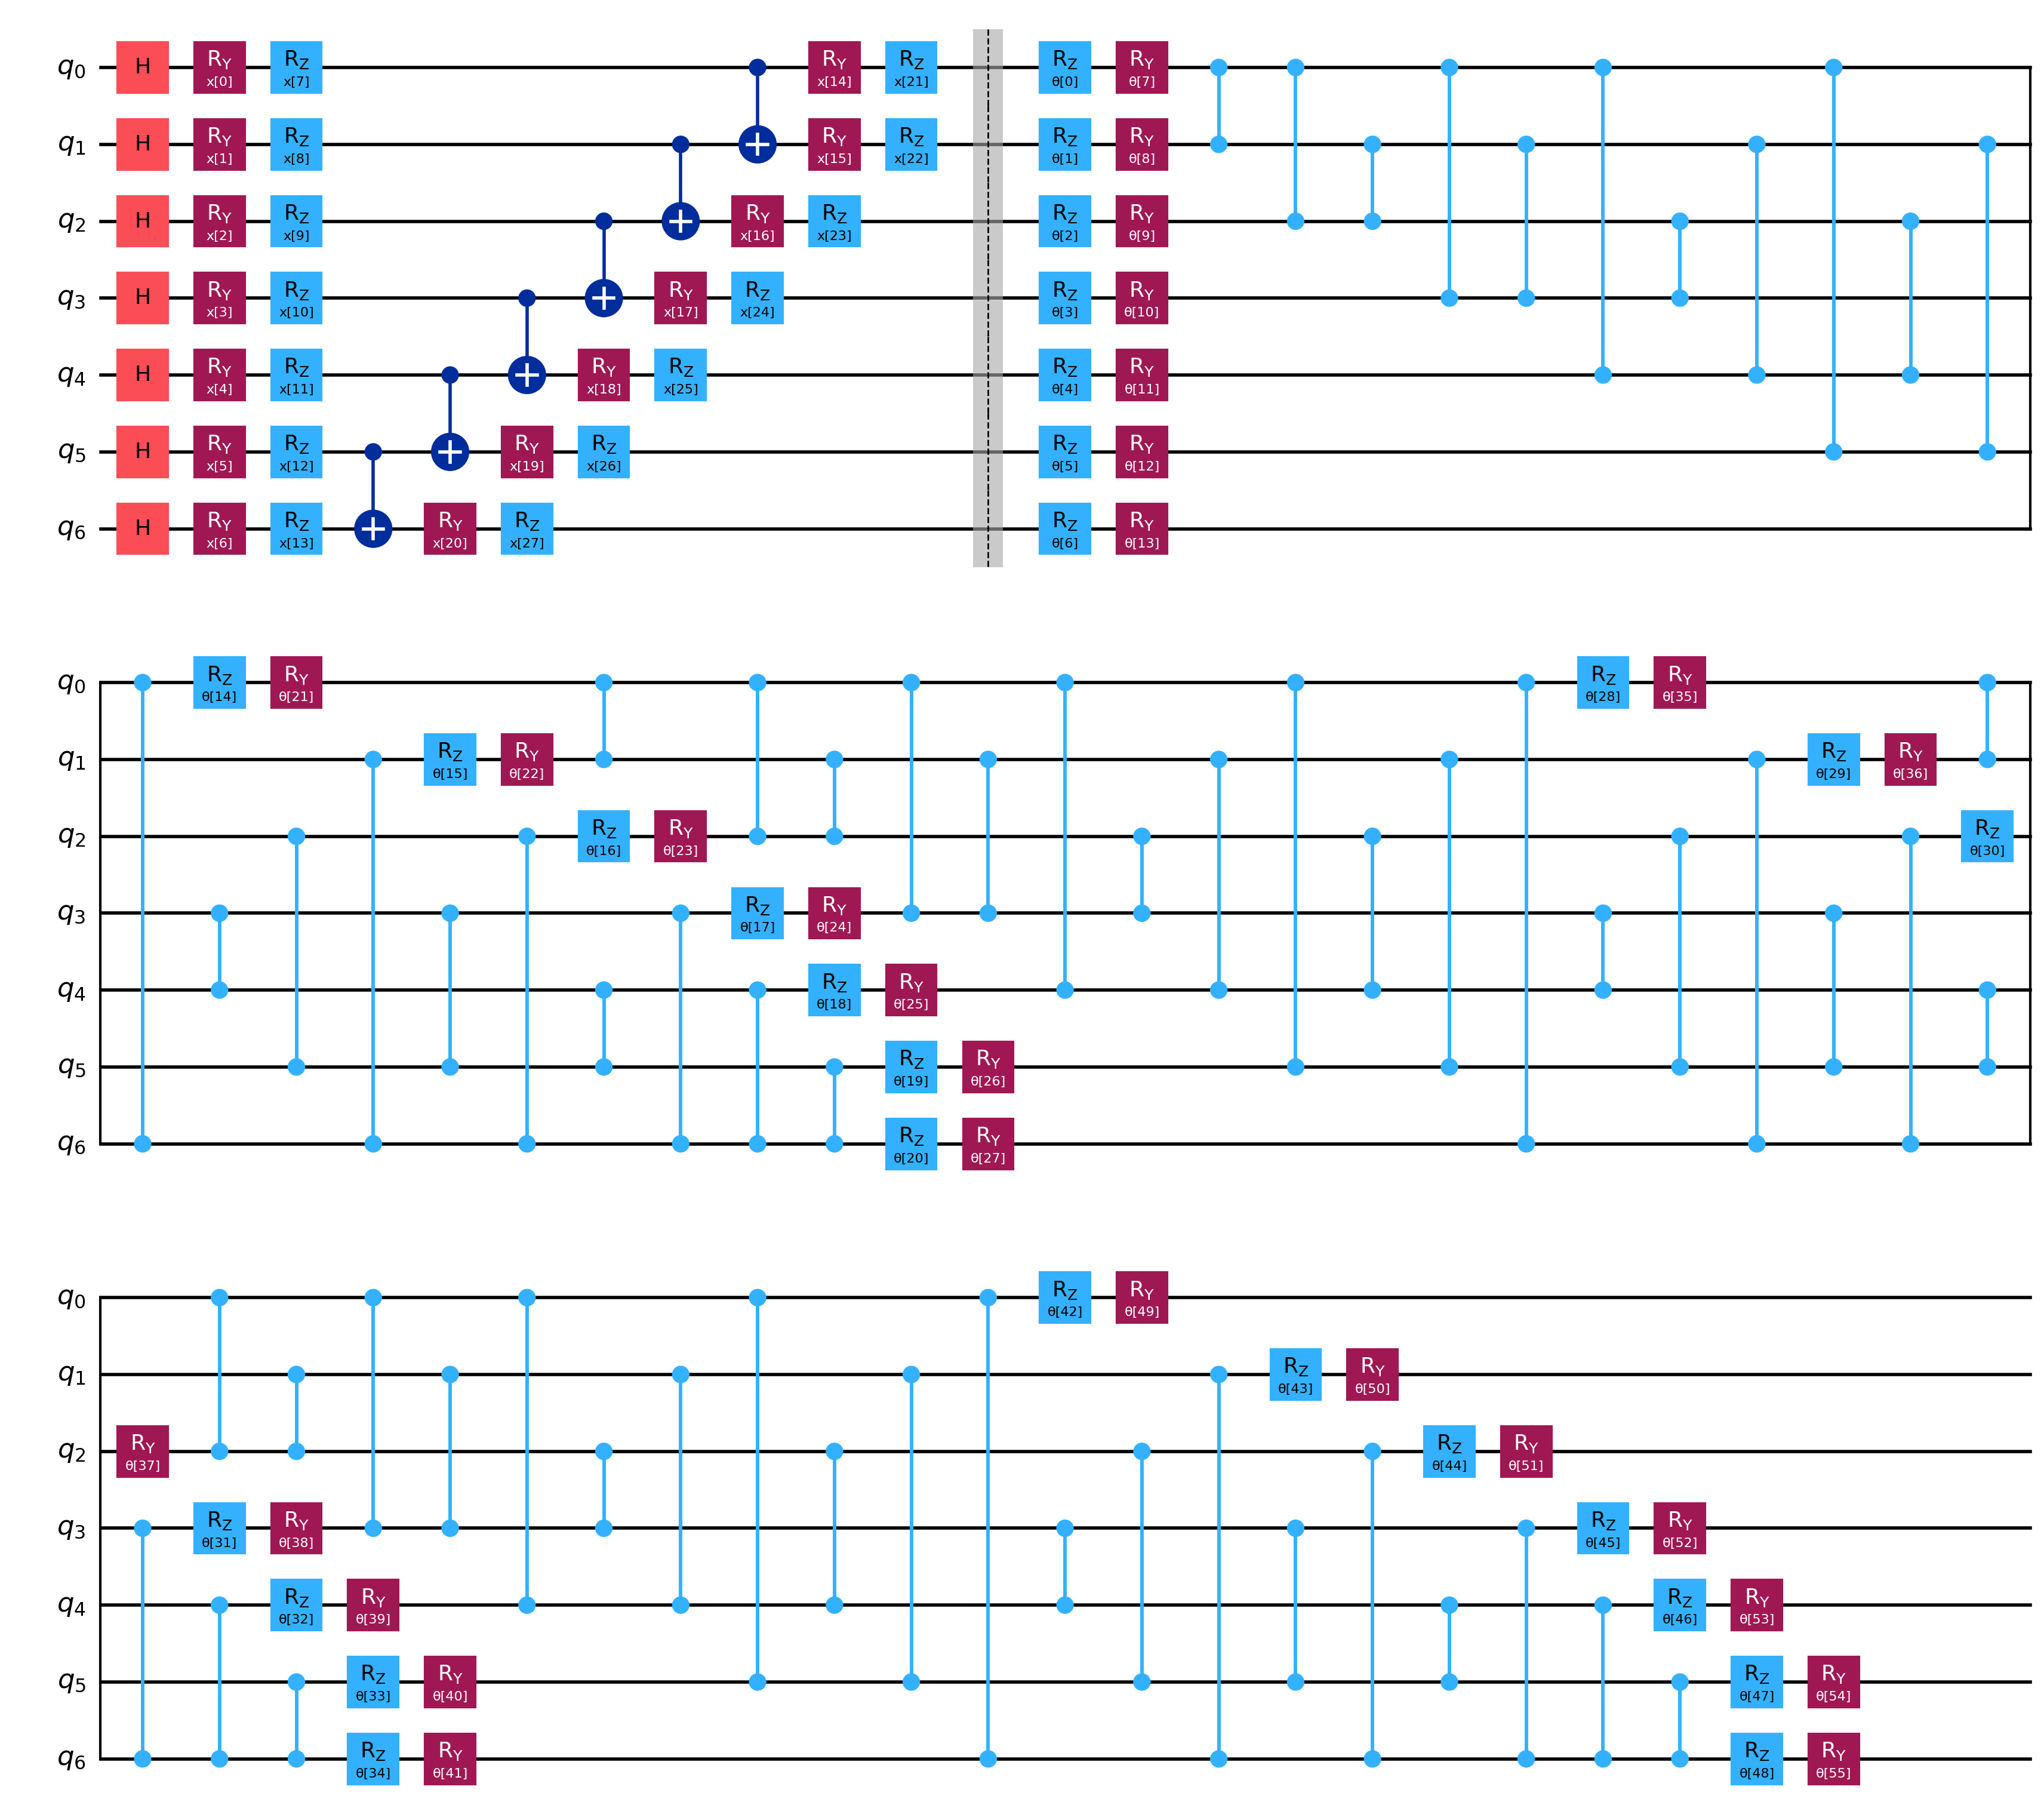

In [29]:
qc_test = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    qc_test.h(i)
# qc_test.draw(output='mpl', scale=2, style='iqx')
featuremap = EfficientSU2(num_qubits=num_qubits, reps=1,
                          parameter_prefix='x', skip_unentangled_qubits=True,
                          initial_state=qc_test
                         )
ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])
qc = QuantumCircuit(num_qubits)

qc.compose(featuremap, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output='mpl', scale=2, style='iqx')

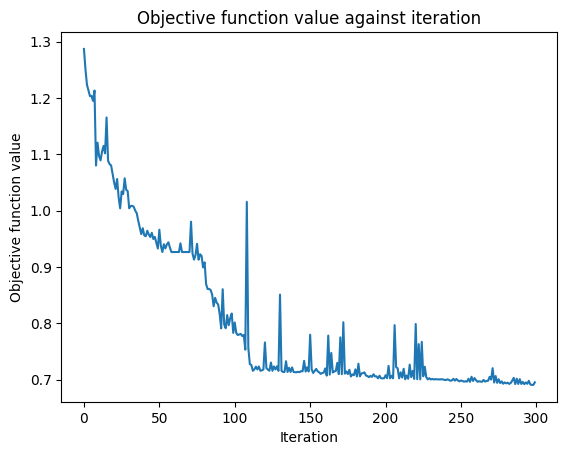

Precision:
 [0.8503000923361034, 0.8245614035087719, 0.8544182146542828, 0.8498281175912755, 0.8702579097315939, 0.8409536662168241, 0.8948807917228969, 0.8503000923361034, 0.8589293747188484, 0.8503028404344194]
Accuracy:
 [0.8508771929824561, 0.8245614035087719, 0.8508771929824561, 0.8508771929824561, 0.868421052631579, 0.8421052631578947, 0.8947368421052632, 0.8508771929824561, 0.8596491228070176, 0.8508771929824561]
Recalls:
 [0.8298395021290534, 0.8132983950212905, 0.8206681952178185, 0.8344251555846709, 0.8439240091713069, 0.8227972486079267, 0.8788077301015395, 0.8298395021290534, 0.8414674091057976, 0.8390108090402882]
F1:
 [0.848810739370472, 0.8245614035087719, 0.8466062809039456, 0.8497248522219548, 0.8656823862391514, 0.8404171136159813, 0.8936114090773208, 0.848810739370472, 0.8581485454364276, 0.8505214084161452]
Time:
 [1622.9814097881317, 1600.325579404831, 1516.6507799625397, 1834.4943022727966, 1651.9540512561798, 1776.8285129070282, 1876.7466833591461, 1855.039540767

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', initial_state=qc_test)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8503000923361034, 0.8245614035087719, 0.8544182146542828, 0.8498281175912755, 0.8702579097315939, 0.8409536662168241, 0.8948807917228969, 0.8503000923361034, 0.8589293747188484, 0.8503028404344194]
Accuracy:
 [0.8508771929824561, 0.8245614035087719, 0.8508771929824561, 0.8508771929824561, 0.868421052631579, 0.8421052631578947, 0.8947368421052632, 0.8508771929824561, 0.8596491228070176, 0.8508771929824561]
Recalls:
 [0.8298395021290534, 0.8132983950212905, 0.8206681952178185, 0.8344251555846709, 0.8439240091713069, 0.8227972486079267, 0.8788077301015395, 0.8298395021290534, 0.8414674091057976, 0.8390108090402882]
F1:
 [0.848810739370472, 0.8245614035087719, 0.8466062809039456, 0.8497248522219548, 0.8656823862391514, 0.8404171136159813, 0.8936114090773208, 0.848810739370472, 0.8581485454364276, 0.8505214084161452]
Time:
 [1622.9814097881317, 1600.325579404831, 1516.6507799625397, 1834.4943022727966, 1651.9540512561798, 1776.8285129070282, 1876.7466833591461, 1855.0395407676697, 1689.2038831710815, 1489.3970499038696]
Mean Precision: 0.854473250325112±0.017473072867497916
Mean Accuracy: 0.8543859649122807±0.01718940170374161
Mean Recall: 0.8390108090402882±0.0
Mean F1: 0.8526894878160644±0.01701647752146968
Mean Time: 1691.3621792793274±132.20598674691595


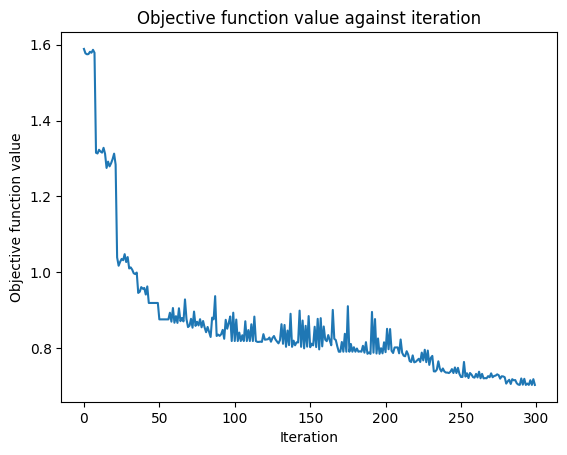

Precision:
 [0.8503028404344194, 0.841085339476322, 0.8233539076558754, 0.8498281175912755, 0.8517956215324636, 0.8702579097315939, 0.9046629732225299, 0.8326719576719577, 0.8503000923361034, 0.8947368421052632]
Accuracy:
 [0.8508771929824561, 0.8421052631578947, 0.8245614035087719, 0.8508771929824561, 0.8508771929824561, 0.868421052631579, 0.9035087719298246, 0.8333333333333334, 0.8508771929824561, 0.8947368421052632]
Recalls:
 [0.8390108090402882, 0.8273829020635441, 0.8087127415656731, 0.8344251555846709, 0.825253848673436, 0.8439240091713069, 0.8858499836226662, 0.8203406485424173, 0.8298395021290534, 0.8879790370127743]
F1:
 [0.8505214084161452, 0.8413220551378446, 0.8236911723753828, 0.8497248522219548, 0.8477733710710383, 0.8656823862391514, 0.902171654886776, 0.8329356917592211, 0.848810739370472, 0.8947368421052632]
Time:
 [1573.1745309829712, 1588.3266332149506, 1577.8676550388336, 1439.5537793636322, 1450.1278536319733, 1317.719624042511, 1251.852401971817, 1592.663840055465

In [10]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', initial_state=qc_test)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.8503028404344194, 0.841085339476322, 0.8233539076558754, 0.8498281175912755, 0.8517956215324636, 0.8702579097315939, 0.9046629732225299, 0.8326719576719577, 0.8503000923361034, 0.8947368421052632]
Accuracy:
 [0.8508771929824561, 0.8421052631578947, 0.8245614035087719, 0.8508771929824561, 0.8508771929824561, 0.868421052631579, 0.9035087719298246, 0.8333333333333334, 0.8508771929824561, 0.8947368421052632]
Recalls:
 [0.8390108090402882, 0.8273829020635441, 0.8087127415656731, 0.8344251555846709, 0.825253848673436, 0.8439240091713069, 0.8858499836226662, 0.8203406485424173, 0.8298395021290534, 0.8879790370127743]
F1:
 [0.8505214084161452, 0.8413220551378446, 0.8236911723753828, 0.8497248522219548, 0.8477733710710383, 0.8656823862391514, 0.902171654886776, 0.8329356917592211, 0.848810739370472, 0.8947368421052632]
Time:
 [1573.1745309829712, 1588.3266332149506, 1577.8676550388336, 1439.5537793636322, 1450.1278536319733, 1317.719624042511, 1251.852401971817, 1592.6638400554657, 1679.6982114315033, 1604.7980868816376]
Mean Precision: 0.8568995601757804±0.02452947474357161
Mean Accuracy: 0.8570175438596491±0.023878346647045974
Mean Recall: 0.8402718637405832±0.025092197243889502
Mean F1: 0.855737017358325±0.02388606647326005
Mean Time: 1507.5782616615295±130.93899083974142


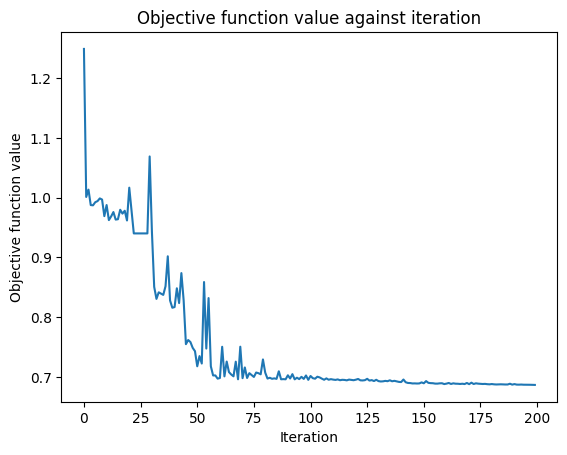

Precision:
 [0.8600555442660707, 0.8770862246895128, 0.8589293747188484]
Accuracy:
 [0.8596491228070176, 0.8596491228070176, 0.8596491228070176]
Recalls:
 [0.8368817556501802, 0.8185391418277105, 0.8414674091057976]
F1:
 [0.8572309151256519, 0.8523016944069576, 0.8581485454364276]
Time:
 [718.1263976097107, 1162.6158232688904, 693.4383218288422]
Mean Precision: 0.8653570478914773±0.008306513738504795
Mean Accuracy: 0.8596491228070176±0.0
Mean Recall: 0.8322961021945628±0.009906143659538178
Mean F1: 0.8558937183230123±0.0025674225995403347
Mean Time: 858.0601809024811±215.58908405320932


In [16]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(3):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', initial_state=qc_test)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

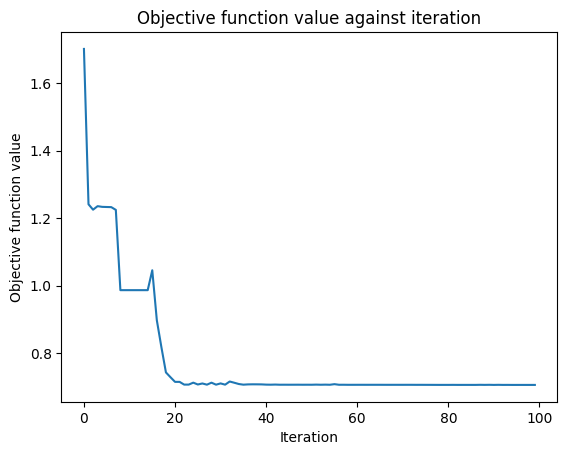

Precision:
 [0.841085339476322, 0.841085339476322]
Accuracy:
 [0.8421052631578947, 0.8421052631578947]
Recalls:
 [0.8273829020635441, 0.8273829020635441]
F1:
 [0.8413220551378446, 0.8413220551378446]
Time:
 [834.6107139587402, 387.6371581554413]
Mean Precision: 0.841085339476322±0.0
Mean Accuracy: 0.8421052631578947±0.0
Mean Recall: 0.8273829020635441±0.0
Mean F1: 0.8413220551378446±0.0
Mean Time: 611.1239360570908±223.48677790164948


In [20]:
times = [834.6107139587402]
precisions =  [0.841085339476322]
accuracies = [0.8421052631578947]
recalls =  [0.8273829020635441]
f1s =  [0.8413220551378446]


for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', initial_state=qc_test)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

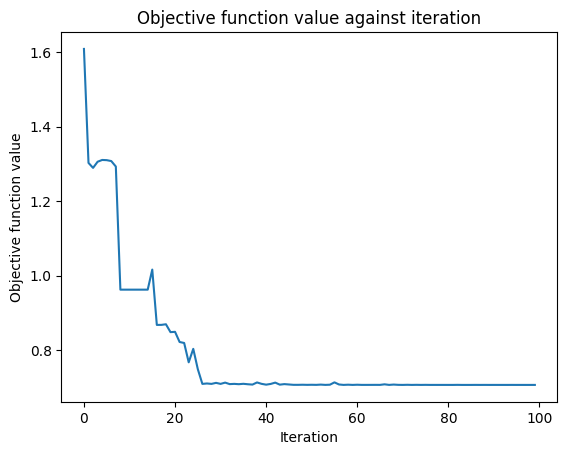

Precision:
 [0.841085339476322, 0.841085339476322]
Accuracy:
 [0.8421052631578947, 0.8421052631578947]
Recalls:
 [0.8273829020635441, 0.8273829020635441]
F1:
 [0.8413220551378446, 0.8413220551378446]
Time:
 [834.6107139587402, 389.72936034202576]
Mean Precision: 0.841085339476322±0.0
Mean Accuracy: 0.8421052631578947±0.0
Mean Recall: 0.8273829020635441±0.0
Mean F1: 0.8413220551378446±0.0
Mean Time: 612.170037150383±222.44067680835724


In [28]:
times = [834.6107139587402]
precisions =  [0.841085339476322]
accuracies = [0.8421052631578947]
recalls =  [0.8273829020635441]
f1s =  [0.8413220551378446]


for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', initial_state=qc_test)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)
  

  objective_func_vals = []

  vqc = VQC(
      num_qubits=num_qubits,
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

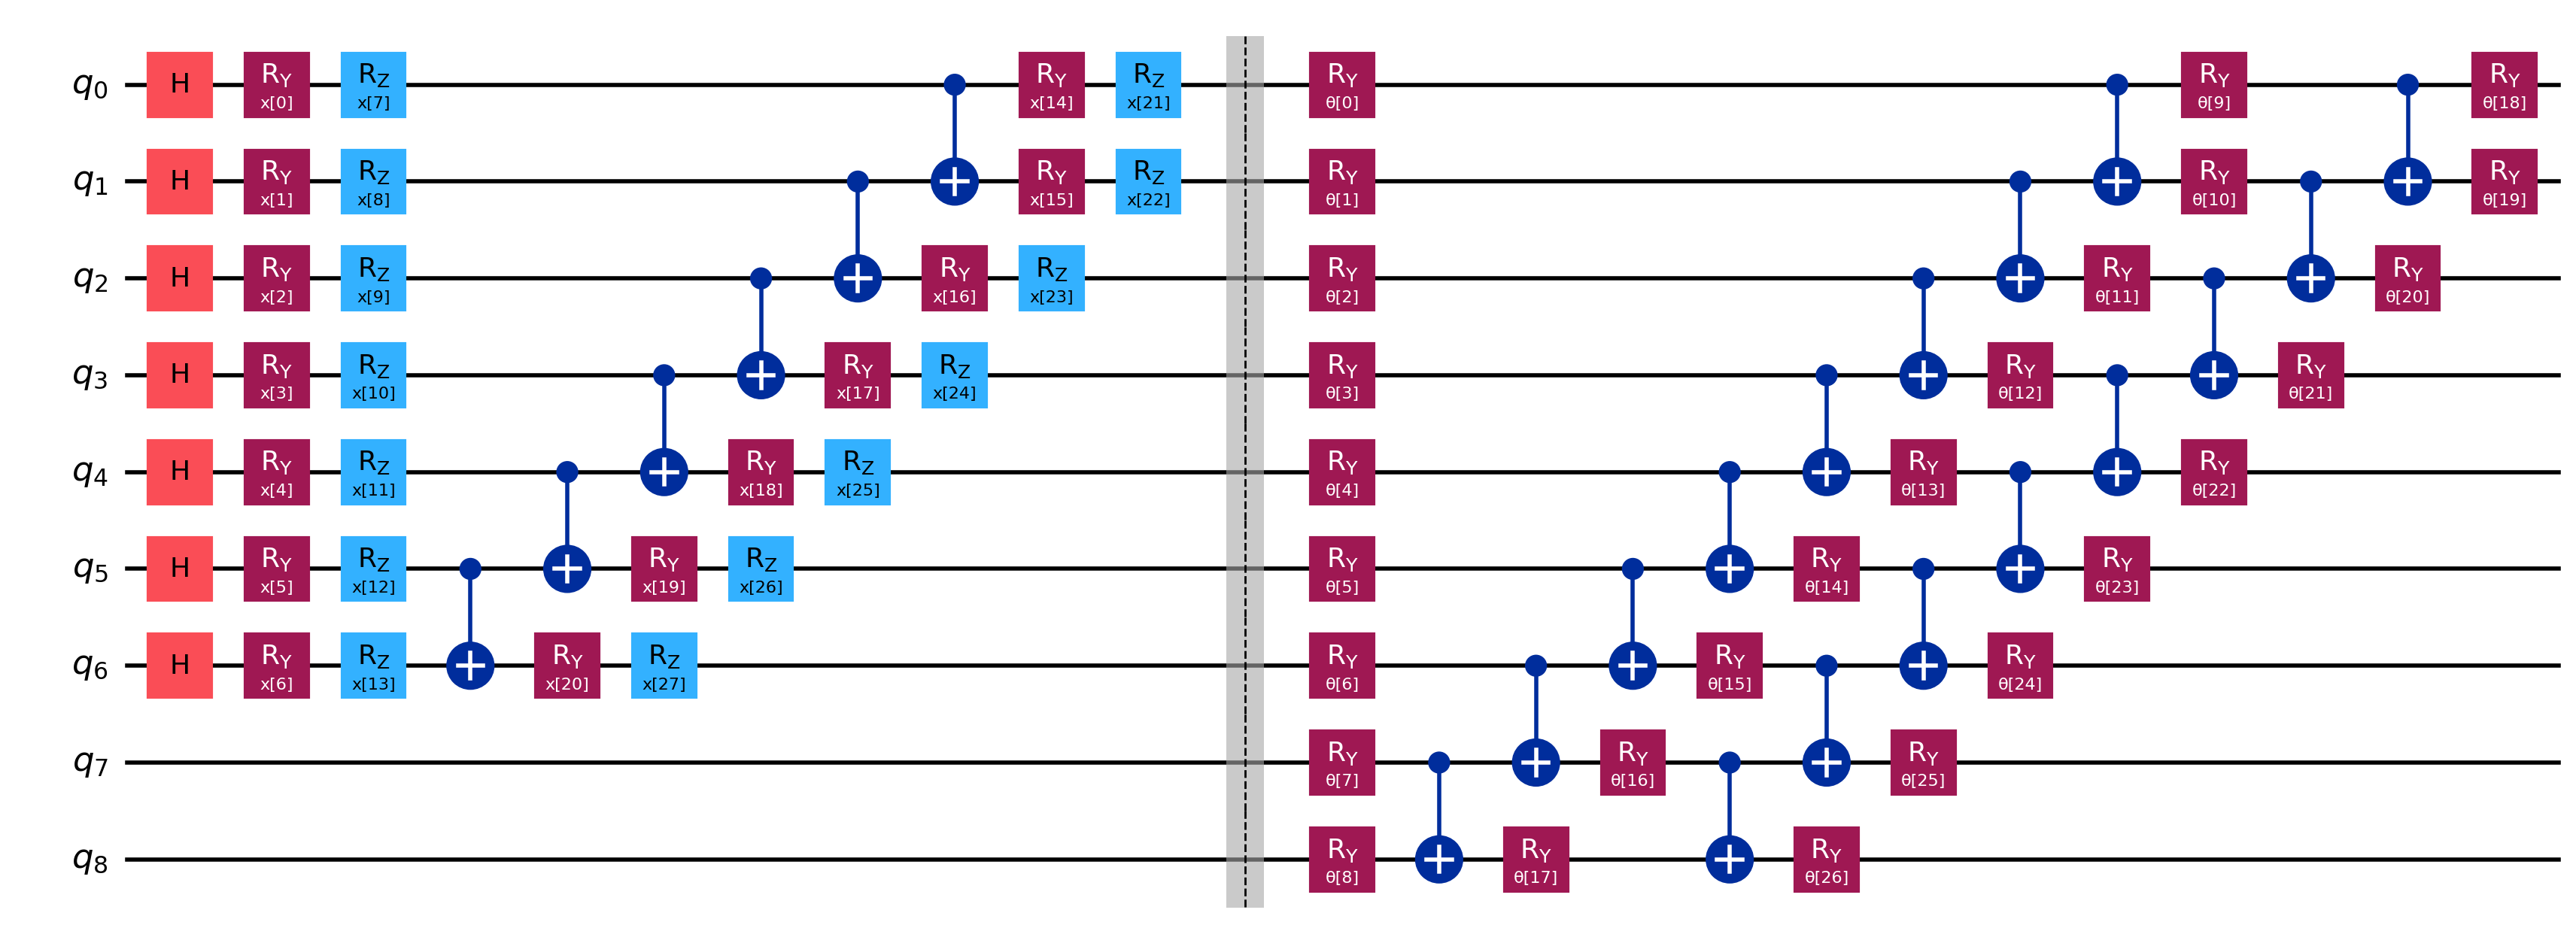

In [33]:
featuremap = EfficientSU2(num_qubits=num_qubits,
                          skip_unentangled_qubits=True,
                          reps=1, parameter_prefix='x', initial_state=qc_test)
ansatz = RealAmplitudes(num_qubits=num_qubits+2, reps=2)
qc = QuantumCircuit(num_qubits+2)
qc.compose(featuremap, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output='mpl', scale=2, style='iqx')

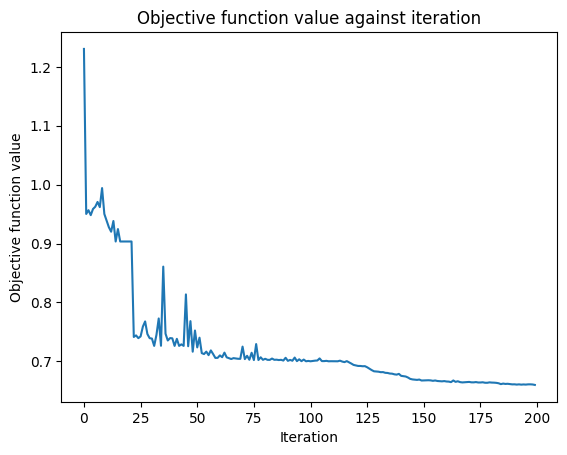

Precision:
 [0.8732972136222911]
Accuracy:
 [0.868421052631579]
Recalls:
 [0.8393383557156895]
F1:
 [0.864652600797599]
Time:
 [637.0877933502197]
Mean Precision: 0.8732972136222911±0.0
Mean Accuracy: 0.868421052631579±0.0
Mean Recall: 0.8393383557156895±0.0
Mean F1: 0.864652600797599±0.0
Mean Time: 637.0877933502197±0.0


In [17]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', initial_state=qc_test)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [ ]:
Precision:
 [0.8732972136222911]
Accuracy:
 [0.868421052631579]
Recalls:
 [0.8393383557156895]
F1:
 [0.864652600797599]
Time:
 [637.0877933502197]
Mean Precision: 0.8732972136222911±0.0
Mean Accuracy: 0.868421052631579±0.0
Mean Recall: 0.8393383557156895±0.0
Mean F1: 0.864652600797599±0.0
Mean Time: 637.0877933502197±0.0

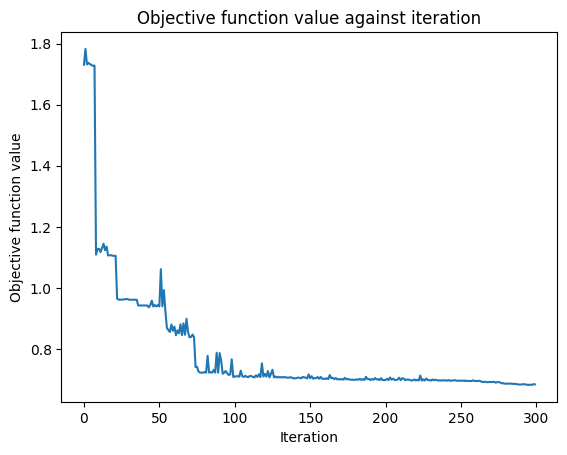

Precision:
 [0.8321791320406279]
Accuracy:
 [0.8333333333333334]
Recalls:
 [0.8111693416311825]
F1:
 [0.831023767531704]
Time:
 [1288.7080962657928]
Mean Precision: 0.8321791320406279±0.0
Mean Accuracy: 0.8333333333333334±0.0
Mean Recall: 0.8111693416311825±0.0
Mean F1: 0.831023767531704±0.0
Mean Time: 1288.7080962657928±0.0


In [14]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', initial_state=qc_test)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [7]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
elapsed = time.time() - start
preds = vqc.predict(X_test)
precision = precision_score(Y_test, preds, average='weighted')
accuracy = accuracy_score(Y_test, preds)
for i in range(1):
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.7778162511542014]
Accuracy:
 [0.7807017543859649]
Recalls:
 [0.7551588601375696]
F1:
 [0.7776628520154001]
Time:
 [1675.131340265274]
Mean Precision: 0.7778162511542014±0.0
Mean Accuracy: 0.7807017543859649±0.0
Mean Recall: 0.7551588601375696±0.0
Mean F1: 0.7776628520154001±0.0
Mean Time: 1675.131340265274±0.0


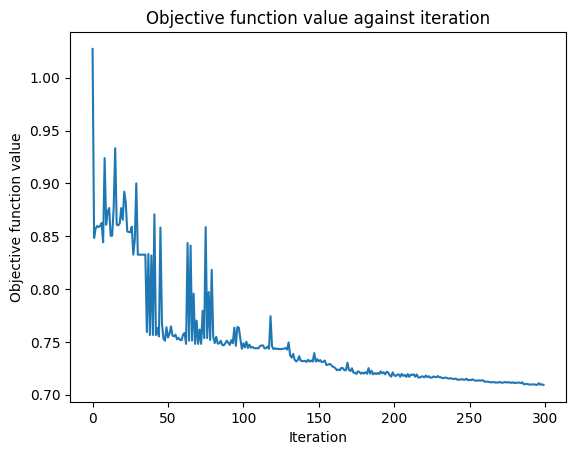

Precision:
 [0.780775299529311]
Accuracy:
 [0.7807017543859649]
Recalls:
 [0.7414018997707174]
F1:
 [0.7725031533081069]
Time:
 [1205.0498218536377]
Mean Precision: 0.780775299529311±0.0
Mean Accuracy: 0.7807017543859649±0.0
Mean Recall: 0.7414018997707174±0.0
Mean F1: 0.7725031533081069±0.0
Mean Time: 1205.0498218536377±0.0


In [36]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 300
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)
  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

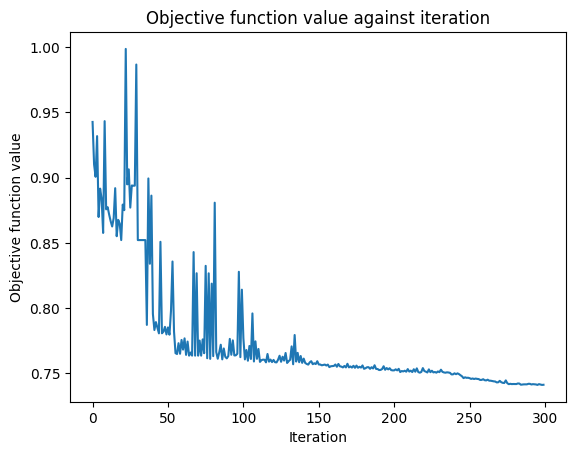

Precision:
 [0.780775299529311, 0.751038651623447, 0.780775299529311, 0.7637009189640769, 0.761392811296534, 0.780775299529311, 0.7722571099337929, 0.8166602167182662, 0.780775299529311, 0.7789022187822497]
Accuracy:
 [0.7807017543859649, 0.7543859649122807, 0.7807017543859649, 0.7631578947368421, 0.7631578947368421, 0.7807017543859649, 0.7719298245614035, 0.8157894736842105, 0.7807017543859649, 0.7807017543859649]
Recalls:
 [0.7414018997707174, 0.7156894857517195, 0.7414018997707174, 0.7181460858172289, 0.7227317392728464, 0.7414018997707174, 0.7297739927939731, 0.7833278742220766, 0.7414018997707174, 0.7459875532263347]
F1:
 [0.7725031533081069, 0.7463065558633425, 0.7725031533081069, 0.7520013024164476, 0.7543034055727555, 0.7725031533081069, 0.7623234991656045, 0.8105136411166387, 0.7725031533081069, 0.7744210013293317]
Time:
 [1130.7114939689636, 1055.3139638900757, 1087.5899379253387, 1032.5953304767609, 1123.4567530155182, 1190.686475276947, 1206.9596166610718, 1154.016727209091

In [37]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 300
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=4)
  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

Precision:
 [0.780775299529311, 0.751038651623447, 0.780775299529311, 0.7637009189640769, 0.761392811296534, 0.780775299529311, 0.7722571099337929, 0.8166602167182662, 0.780775299529311, 0.7789022187822497]
Accuracy:
 [0.7807017543859649, 0.7543859649122807, 0.7807017543859649, 0.7631578947368421, 0.7631578947368421, 0.7807017543859649, 0.7719298245614035, 0.8157894736842105, 0.7807017543859649, 0.7807017543859649]
Recalls:
 [0.7414018997707174, 0.7156894857517195, 0.7414018997707174, 0.7181460858172289, 0.7227317392728464, 0.7414018997707174, 0.7297739927939731, 0.7833278742220766, 0.7414018997707174, 0.7459875532263347]
F1:
 [0.7725031533081069, 0.7463065558633425, 0.7725031533081069, 0.7520013024164476, 0.7543034055727555, 0.7725031533081069, 0.7623234991656045, 0.8105136411166387, 0.7725031533081069, 0.7744210013293317]
Time:
 [1130.7114939689636, 1055.3139638900757, 1087.5899379253387, 1032.5953304767609, 1123.4567530155182, 1190.686475276947, 1206.9596166610718, 1154.0167272090912, 1156.749089717865, 1209.9404196739197]
Mean Precision: 0.776705312543561±0.01658201096653885
Mean Accuracy: 0.7771929824561403±0.015789473684210513
Mean Recall: 0.7459875532263347±0.0
Mean F1: 0.7689882018696548±0.016930358153584818
Mean Time: 1134.8019807815551±58.279872745911035


In [6]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(1):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x', initial_state=qc_test)
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

# **Non Nececerry**

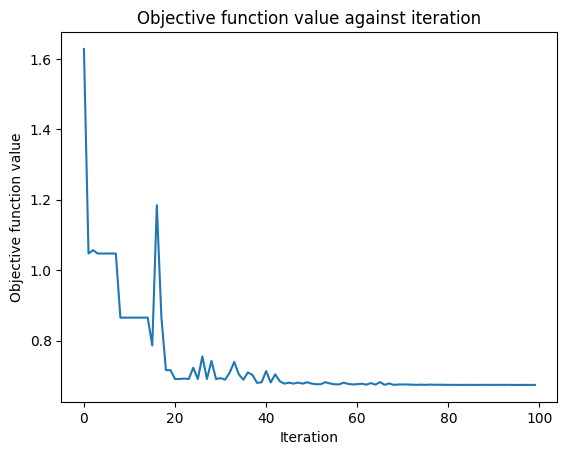

Precision:
 [0.8544182146542828, 0.81917149010634, 0.8600555442660707, 0.8319819819819819, 0.8517956215324636, 0.876548203117215, 0.8600555442660707, 0.7531731791600214, 0.8596491228070176, 0.796289710763395]
Accuracy:
 [0.8508771929824561, 0.8157894736842105, 0.8596491228070176, 0.8333333333333334, 0.8508771929824561, 0.8771929824561403, 0.8596491228070176, 0.7456140350877193, 0.8596491228070176, 0.7982456140350878]
Recalls:
 [0.8206681952178185, 0.8108417949557811, 0.8368817556501802, 0.8157549950867999, 0.825253848673436, 0.864723223059286, 0.8368817556501802, 0.7407468064199147, 0.8506387160170324, 0.778414674091058]
F1:
 [0.8466062809039456, 0.8169062620985412, 0.8572309151256519, 0.8320454230715968, 0.8477733710710383, 0.8765838206627681, 0.8572309151256519, 0.7479605808457135, 0.8596491228070176, 0.7966865647708803]
Time:
 [246.83904218673706, 247.41161060333252, 237.82569646835327, 236.13514161109924, 236.16179037094116, 238.4629397392273, 245.55061841011047, 293.2007586956024,

In [16]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=1)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recalls)
  r_std = np.std(recalls)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

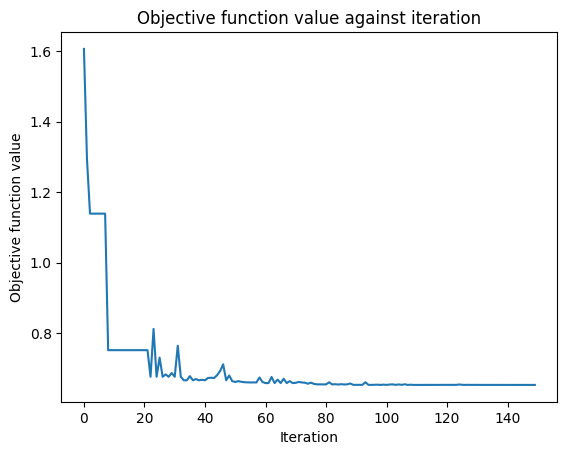

Precision:
 [0.7992595124174071, 0.8233539076558754, 0.8091533180778032, 0.7743368082040851, 0.8657530470395968, 0.8409536662168241, 0.8233539076558754, 0.8120093819814701, 0.8600555442660707, 0.8657530470395968]
Accuracy:
 [0.7982456140350878, 0.8245614035087719, 0.8070175438596491, 0.7719298245614035, 0.8596491228070176, 0.8421052631578947, 0.8245614035087719, 0.8070175438596491, 0.8596491228070176, 0.8596491228070176]
Recalls:
 [0.7875859810022928, 0.8087127415656731, 0.799213887979037, 0.7618735669832951, 0.8277104487389453, 0.8227972486079267, 0.8087127415656731, 0.8037995414346544, 0.8368817556501802, 0.8277104487389453]
F1:
 [0.7986896809154214, 0.8236911723753828, 0.8078320802005011, 0.7728924584187742, 0.8550323176361957, 0.8404171136159813, 0.8236911723753828, 0.8085091956945503, 0.8572309151256519, 0.8550323176361957]
Time:
 [505.46540880203247, 501.7453832626343, 496.0059142112732, 504.1972966194153, 496.1642806529999, 405.46852445602417, 400.8906738758087, 403.519418716430

In [13]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 150
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=2)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

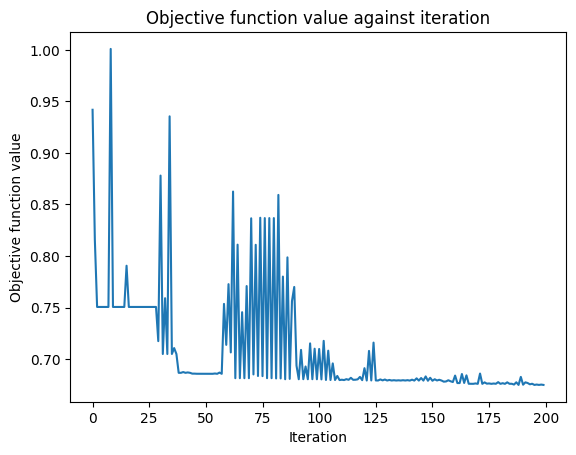

Precision:
 [0.8517956215324636, 0.8319819819819819, 0.8319819819819819, 0.8600555442660707, 0.8769050832208728, 0.8732972136222911, 0.876548203117215, 0.8588167712967684, 0.8544182146542828, 0.81917149010634]
Accuracy:
 [0.8508771929824561, 0.8333333333333334, 0.8333333333333334, 0.8596491228070176, 0.8771929824561403, 0.868421052631579, 0.8771929824561403, 0.8596491228070176, 0.8508771929824561, 0.8157894736842105]
Recalls:
 [0.825253848673436, 0.8157549950867999, 0.8157549950867999, 0.8368817556501802, 0.8601375696036685, 0.8393383557156895, 0.864723223059286, 0.846053062561415, 0.8206681952178185, 0.8108417949557811]
F1:
 [0.8477733710710383, 0.8320454230715968, 0.8320454230715968, 0.8572309151256519, 0.8758799772568742, 0.864652600797599, 0.8765838206627681, 0.8589529379003062, 0.8466062809039456, 0.8169062620985412]
Time:
 [642.1614475250244, 604.6662740707397, 687.167022228241, 708.1185579299927, 588.3049929141998, 602.5867986679077, 749.3513479232788, 636.2301695346832, 597.289

In [17]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 200
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=3)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

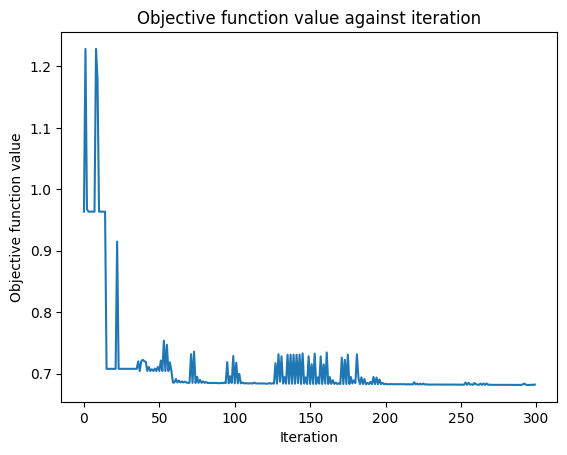

Precision:
 [0.8691387559808613, 0.8056224758354289, 0.8776877406931964, 0.8141358463726884, 0.8293303917144401, 0.8622886329748422, 0.8588167712967684, 0.7917450631409441, 0.8848721129422884, 0.8517956215324636]
Accuracy:
 [0.868421052631579, 0.8070175438596491, 0.868421052631579, 0.8157894736842105, 0.8245614035087719, 0.8596491228070176, 0.8596491228070176, 0.7894736842105263, 0.8771929824561403, 0.8508771929824561]
Recalls:
 [0.8622666229937767, 0.7900425810678021, 0.834752702260072, 0.7970848345889289, 0.8224697019325253, 0.8322961021945627, 0.846053062561415, 0.7805437274811661, 0.8463806092368162, 0.825253848673436]
F1:
 [0.8687106614665793, 0.8060602896129212, 0.8635018919848643, 0.8143659939212384, 0.8259174506314094, 0.8561943319838056, 0.8589529379003062, 0.7903622693096377, 0.8731532779316713, 0.8477733710710383]
Time:
 [1122.3107206821442, 962.2481293678284, 958.0115323066711, 956.1487152576447, 1013.2894248962402, 991.812750339508, 1068.2873215675354, 1044.8040294647217, 

In [6]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(10):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x',initial_state=qc_test)
  ansatz = PauliTwoDesign(num_qubits=num_qubits, reps=4)
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

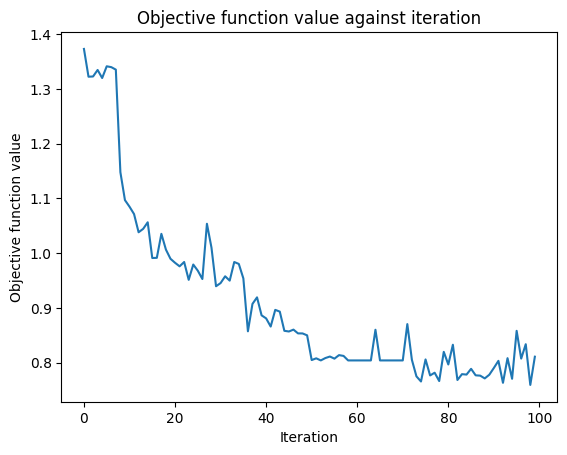

[0.7719298245614035]
[903.4415531158447]


In [13]:
times = []
scores = []
for i in range(1):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)


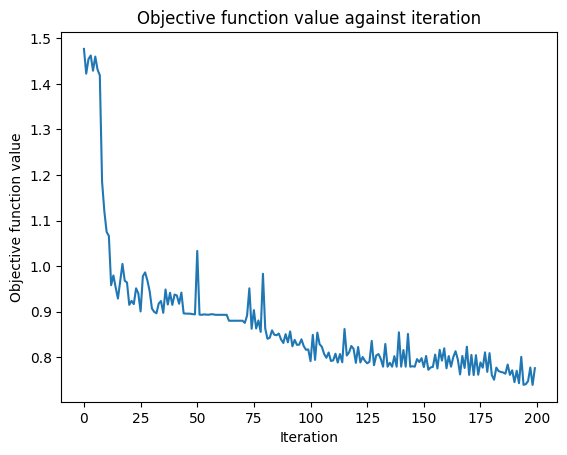

[0.7192982456140351]
[1812.384690284729]


In [14]:
times = []
scores = []
for i in range(1):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 200
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)


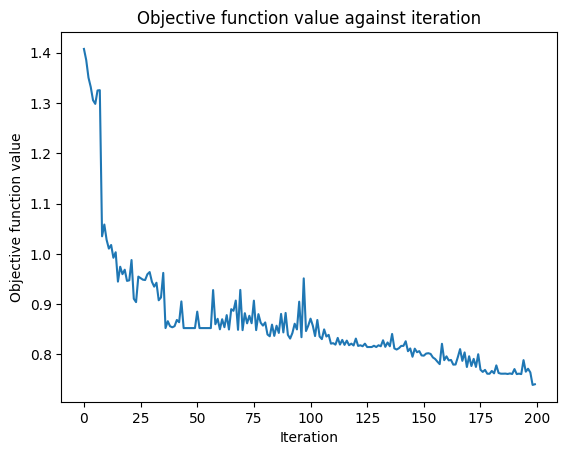

[0.6929824561403509]
[1546.8844575881958]


In [16]:
times = []
scores = []
for i in range(1):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 200
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', su2_gates=['h', 'rz', 'ry'])
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)


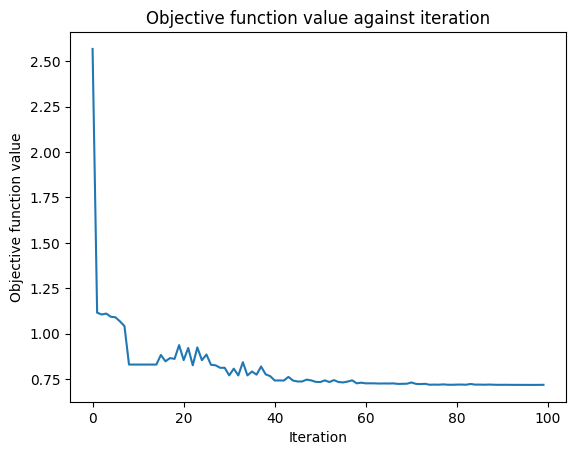

[0.7456140350877193, 0.7456140350877193, 0.6491228070175439, 0.7280701754385965]
[441.03557872772217, 440.894483089447, 447.5383722782135, 455.2197217941284]


In [ ]:

for i in range(3):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)


  objective_func_vals = []


  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)


**Accuracy:**
1. 0.7456140350877193
2. 0.7456140350877193
3. 0.6491228070175439
4. 0.7280701754385965
**Time:**
1. 441.03557872772217
2. 440.894483089447
3. 447.5383722782135
4. 455.2197217941284

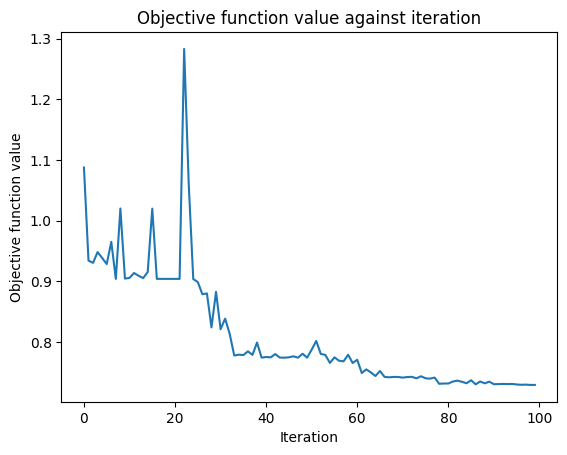

[0.6842105263157895, 0.7368421052631579, 0.7982456140350878, 0.7719298245614035]
[551.4207887649536, 506.3335816860199, 504.02105927467346, 506.7954831123352]


In [ ]:
times = []
scores = []
for i in range(4):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)


**Accuracy:**
1. 0.6842105263157895
2. 0.7368421052631579
3. 0.7982456140350878
4. 0.7719298245614035

**Time:**
1. 551.4207887649536
2. 506.3335816860199
3. 504.02105927467346
4. 506.7954831123352

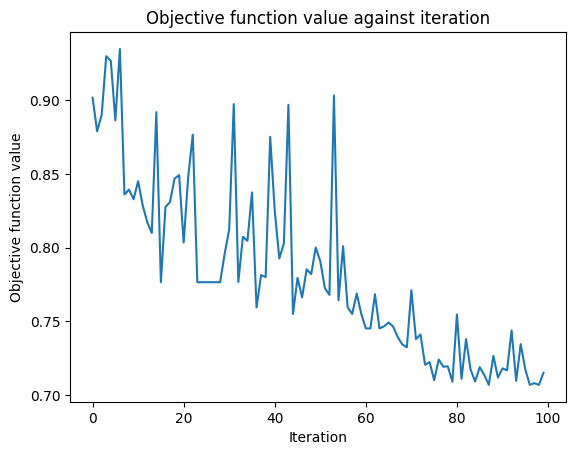

[0.7017543859649122, 0.7017543859649122, 0.7368421052631579, 0.7192982456140351]
[558.4003918170929, 548.6667563915253, 551.9049453735352, 555.4721205234528]


In [ ]:
times = []
scores = []
for i in range(4):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)



**Accuracy:**
1. 0.7017543859649122
2. 0.7017543859649122
3. 0.7368421052631579
4. 0.7192982456140351
**Time:**
1. 558.4003918170929
2. 548.6667563915253
3. 551.9049453735352
4. 555.4721205234528

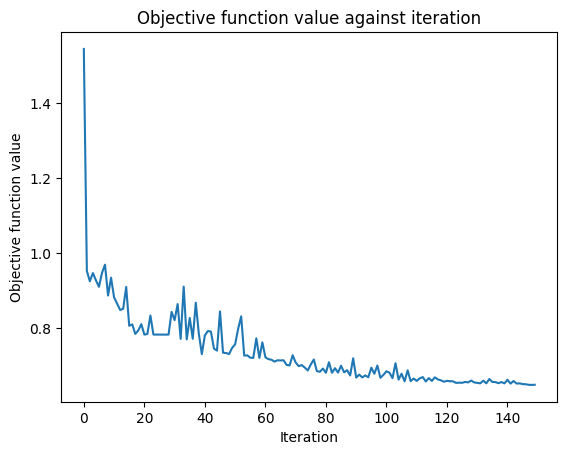

[0.7807017543859649, 0.7982456140350878, 0.7017543859649122, 0.7894736842105263]
[911.400720834732, 887.6249096393585, 828.7457301616669, 823.7465271949768]


In [ ]:
times = []
scores = []
for i in range(4):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)




  objective_func_vals = []

  MAXITR = 150
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)



**Accuracy:**
1. 0.7807017543859649
2. 0.7982456140350878
3. 0.7017543859649122
4. 0.7894736842105263

**Time:**
1. 911.400720834732
2. 887.6249096393585
3. 828.7457301616669
4. 823.7465271949768

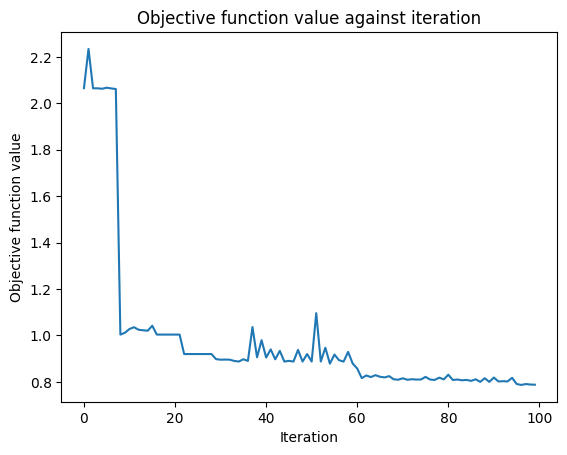

[0.6228070175438597, 0.6491228070175439, 0.6666666666666666, 0.6666666666666666]
[601.4788510799408, 581.1355717182159, 577.1305992603302, 575.5856971740723]


In [ ]:
times = []
scores = []
for i in range(4):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)

**Accuracy:**
1. 0.6228070175438597
2. 0.6491228070175439
3. 0.6666666666666666
4. 0.6666666666666666

**Time:**
1. 601.4788510799408
2. 581.1355717182159
3. 577.1305992603302
4. 575.5856971740723


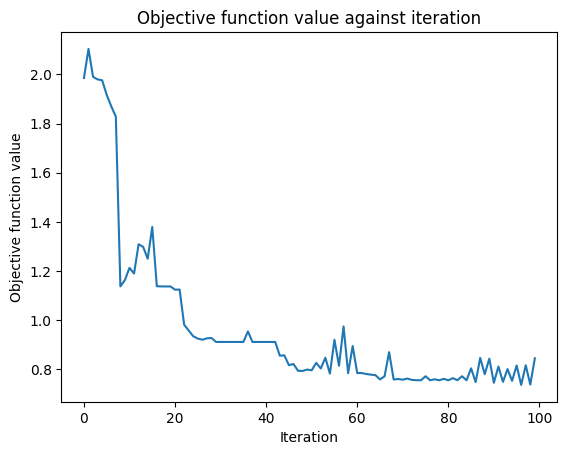

[0.7105263157894737, 0.6929824561403509, 0.6754385964912281, 0.7368421052631579]
[728.593227148056, 765.7406420707703, 744.2984108924866, 777.1064205169678]


In [ ]:
# times = []
# scores = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)

**Accurcay:**
1. 0.7105263157894737
2. 0.6929824561403509
3. 0.6754385964912281
4. 0.7368421052631579
**Time:**
1. 728.593227148056
2. 765.7406420707703
3. 744.2984108924866
4. 777.1064205169678

In [ ]:
print(scores)

print(times)

[0.7105263157894737, 0.6929824561403509, 0.6754385964912281, 0.7894736842105263]
[728.593227148056, 765.7406420707703, 744.2984108924866, 736.2110521793365]


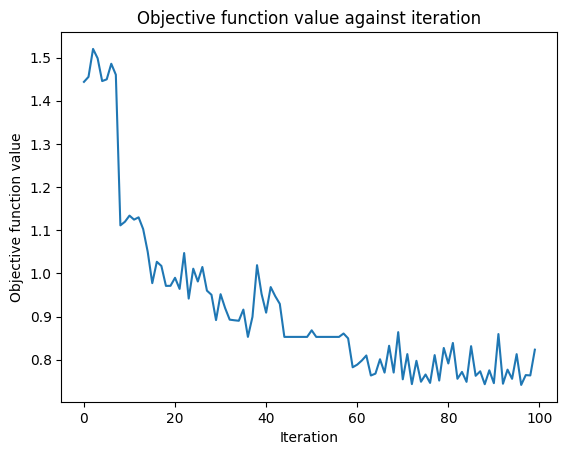

[0.6228070175438597, 0.6491228070175439, 0.7105263157894737, 0.7982456140350878]
[874.1952042579651, 871.6187312602997, 922.200231552124, 871.3403537273407]


In [ ]:
times = []
scores = []
for i in range(4):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)

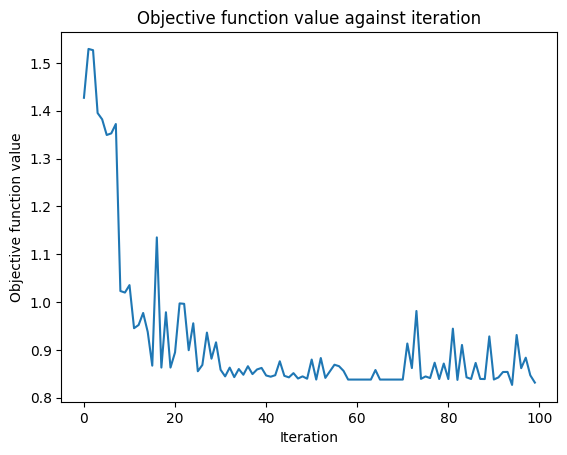

[0.6491228070175439, 0.6491228070175439, 0.631578947368421, 0.6842105263157895]
[1019.028044462204, 1005.0667264461517, 993.1998236179352, 992.8008141517639]


In [ ]:
times = []
scores = []
for i in range(4):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 100
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)

**Accuracy:**
1. 0.6491228070175439
2. 0.6491228070175439
3. 0.631578947368421
4. 0.6842105263157895
**Time:**
1. 1019.028044462204
2. 1005.0667264461517
3. 993.1998236179352
4. 992.8008141517639


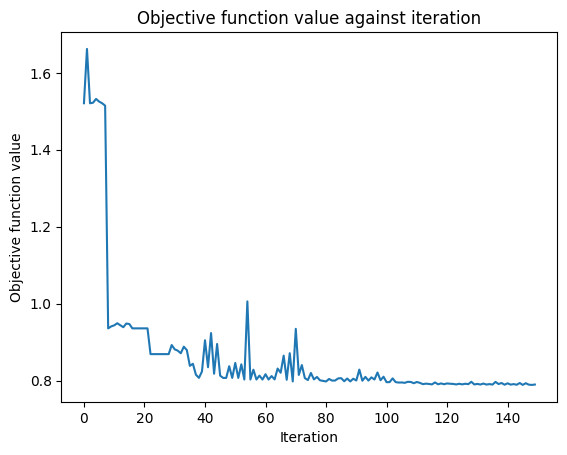

[0.7192982456140351, 0.7017543859649122, 0.6491228070175439, 0.6666666666666666]
[935.4664368629456, 912.2301950454712, 893.1424713134766, 904.0283160209656]


In [ ]:
times = []
scores = []
for i in range(4):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 150
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=1, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)

**Accurcay**
1. 0.7192982456140351
2. 0.7017543859649122
3. 0.6491228070175439
4. 0.6666666666666666

**Time:**
1. 935.4664368629456
2. 912.2301950454712
3. 893.1424713134766
4. 904.0283160209656


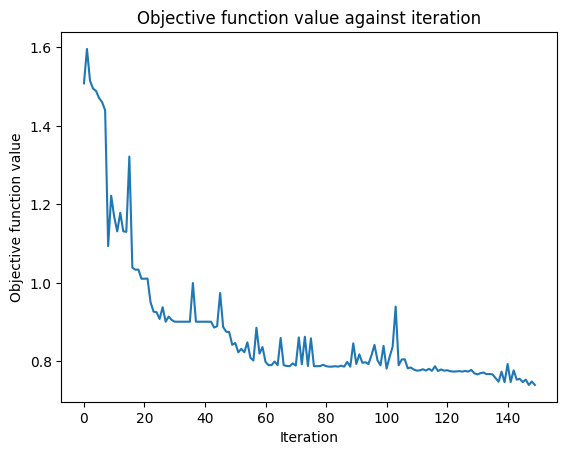

[0.8421052631578947, 0.6842105263157895, 0.7105263157894737, 0.7719298245614035]
[1104.4720940589905, 1136.875913143158, 1085.2966678142548, 1068.8935110569]


In [ ]:
times = []
scores = []
for i in range(4):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 150
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=2, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)

**Accuracy:**
1. 0.8421052631578947
2. 0.6842105263157895
3. 0.7105263157894737
4. 0.7719298245614035
**Time:**
1. 1104.4720940589905
2. 1136.875913143158
3. 1085.2966678142548
4. 1068.8935110569

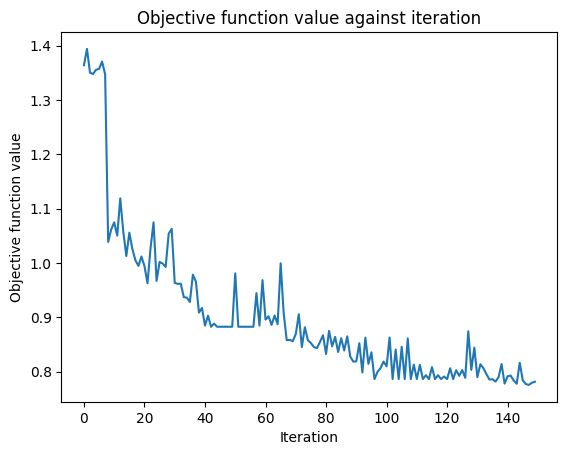

[0.7105263157894737, 0.7631578947368421, 0.7631578947368421, 0.7105263157894737]
[1347.7292284965515, 1265.429475069046, 1257.2910516262054, 1264.7034485340118]


In [ ]:
times = []
scores = []
for i in range(4):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 150
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)

**Accuracy:**
1. 0.7105263157894737
2. 0.7631578947368421
3. 0.7631578947368421
4. 0.7105263157894737

**Time:**
1. 1347.7292284965515
2. 1265.429475069046
3. 1257.2910516262054
4. 1264.7034485340118

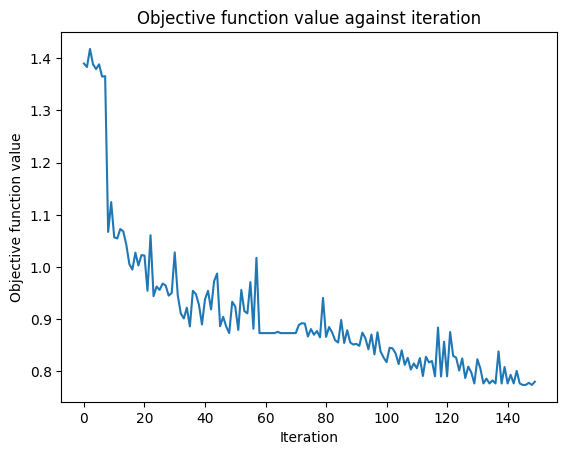

[0.7192982456140351, 0.7894736842105263]
[1483.1625626087189, 1427.6038756370544]


In [ ]:
times = []
scores = []
for i in range(2):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



  for i in range(2):
    rf = RandomForestClassifier(random_state=42)

    rf.fit(X_train, Y_train)

    feature_importances = rf.feature_importances_

    least_important_index = np.argmin(feature_importances)

    X_train = np.delete(X_train, least_important_index, axis=1)

    X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 150
  num_qubits = X.shape[1]//4
  opt = COBYLA(maxiter=MAXITR)

  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x')
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])



  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  scores.append(vqc.score(X_test, Y_test))
  print(scores)
  times.append(elapsed)
  print(times)

In [ ]:
print(scores)

[0.6842105263157895, 0.7543859649122807]


In [ ]:
times

[1346.8083593845367, 1297.6875667572021]

**Accuracy:**
1. 0.6842105263157895
2. 0.7543859649122807
3. 0.7192982456140351
4. 0.7894736842105263

**Time:**
1. 1346.8083593845367
2. 1297.6875667572021
3. 1483.1625626087189
4. 1427.6038756370544

In [ ]:
times = []
precisions = []
accuracies = []
recalls = []
f1s = []
for i in range(1):

  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)



#   for i in range(2):
#     rf = RandomForestClassifier(random_state=42)

#     rf.fit(X_train, Y_train)

#     feature_importances = rf.feature_importances_

#     least_important_index = np.argmin(feature_importances)

#     X_train = np.delete(X_train, least_important_index, axis=1)

#     X_test = np.delete(X_test, least_important_index, axis=1)

  MAXITR = 300
  num_qubits = X.shape[1]//3
  opt = COBYLA(maxiter=MAXITR)
  
  qc_test = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
        qc_test.h(i)
  featuremap = EfficientSU2(num_qubits=num_qubits, reps=1, parameter_prefix='x', initial_state=qc_test)
  ansatz = TwoLocal(num_qubits=num_qubits, reps=4, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])
  qc = QuantumCircuit(num_qubits)
  for i in range(num_qubits):
      qc.h(i)
  qc.compose(featuremap, inplace=True)
  qc.compose(ansatz, inplace=True)

  objective_func_vals = []

  vqc = VQC(
      feature_map=featuremap,
      ansatz=ansatz,
      optimizer=opt,
      callback=callback_graph,
  )

  start = time.time()
  vqc.fit(X_train, Y_train)
  elapsed = time.time() - start
  preds = vqc.predict(X_test)
  precision = precision_score(Y_test, preds, average='weighted')
  accuracy = accuracy_score(Y_test, preds)
  recall = recall_score(Y_test, preds, average='macro')
  f1 = f1_score(Y_test, preds, average='weighted')

  times.append(elapsed)
  precisions.append(precision)
  accuracies.append(accuracy)
  recalls.append(recall)
  f1s.append(f1)

  print("Precision:\n",precisions)
  print("Accuracy:\n",accuracies)
  print("Recalls:\n",recalls)
  print("F1:\n",f1s)
  print("Time:\n",times)
    
  t = np.mean(times)
  t_std = np.std(times)
  p = np.mean(precisions)
  p_std = np.std(precisions)
  a = np.mean(accuracies)
  a_std = np.std(accuracies)
  f = np.mean(f1s)
  f_std = np.std(f1s)
  r = np.mean(recall)
  r_std = np.std(recall)
  
  print(f"Mean Precision: {p}±{p_std}")
  print(f"Mean Accuracy: {a}±{a_std}")
  print(f"Mean Recall: {r}±{r_std}")
  print(f"Mean F1: {f}±{f_std}")
  print(f"Mean Time: {t}±{t_std}")

In [8]:
num_qubits

30

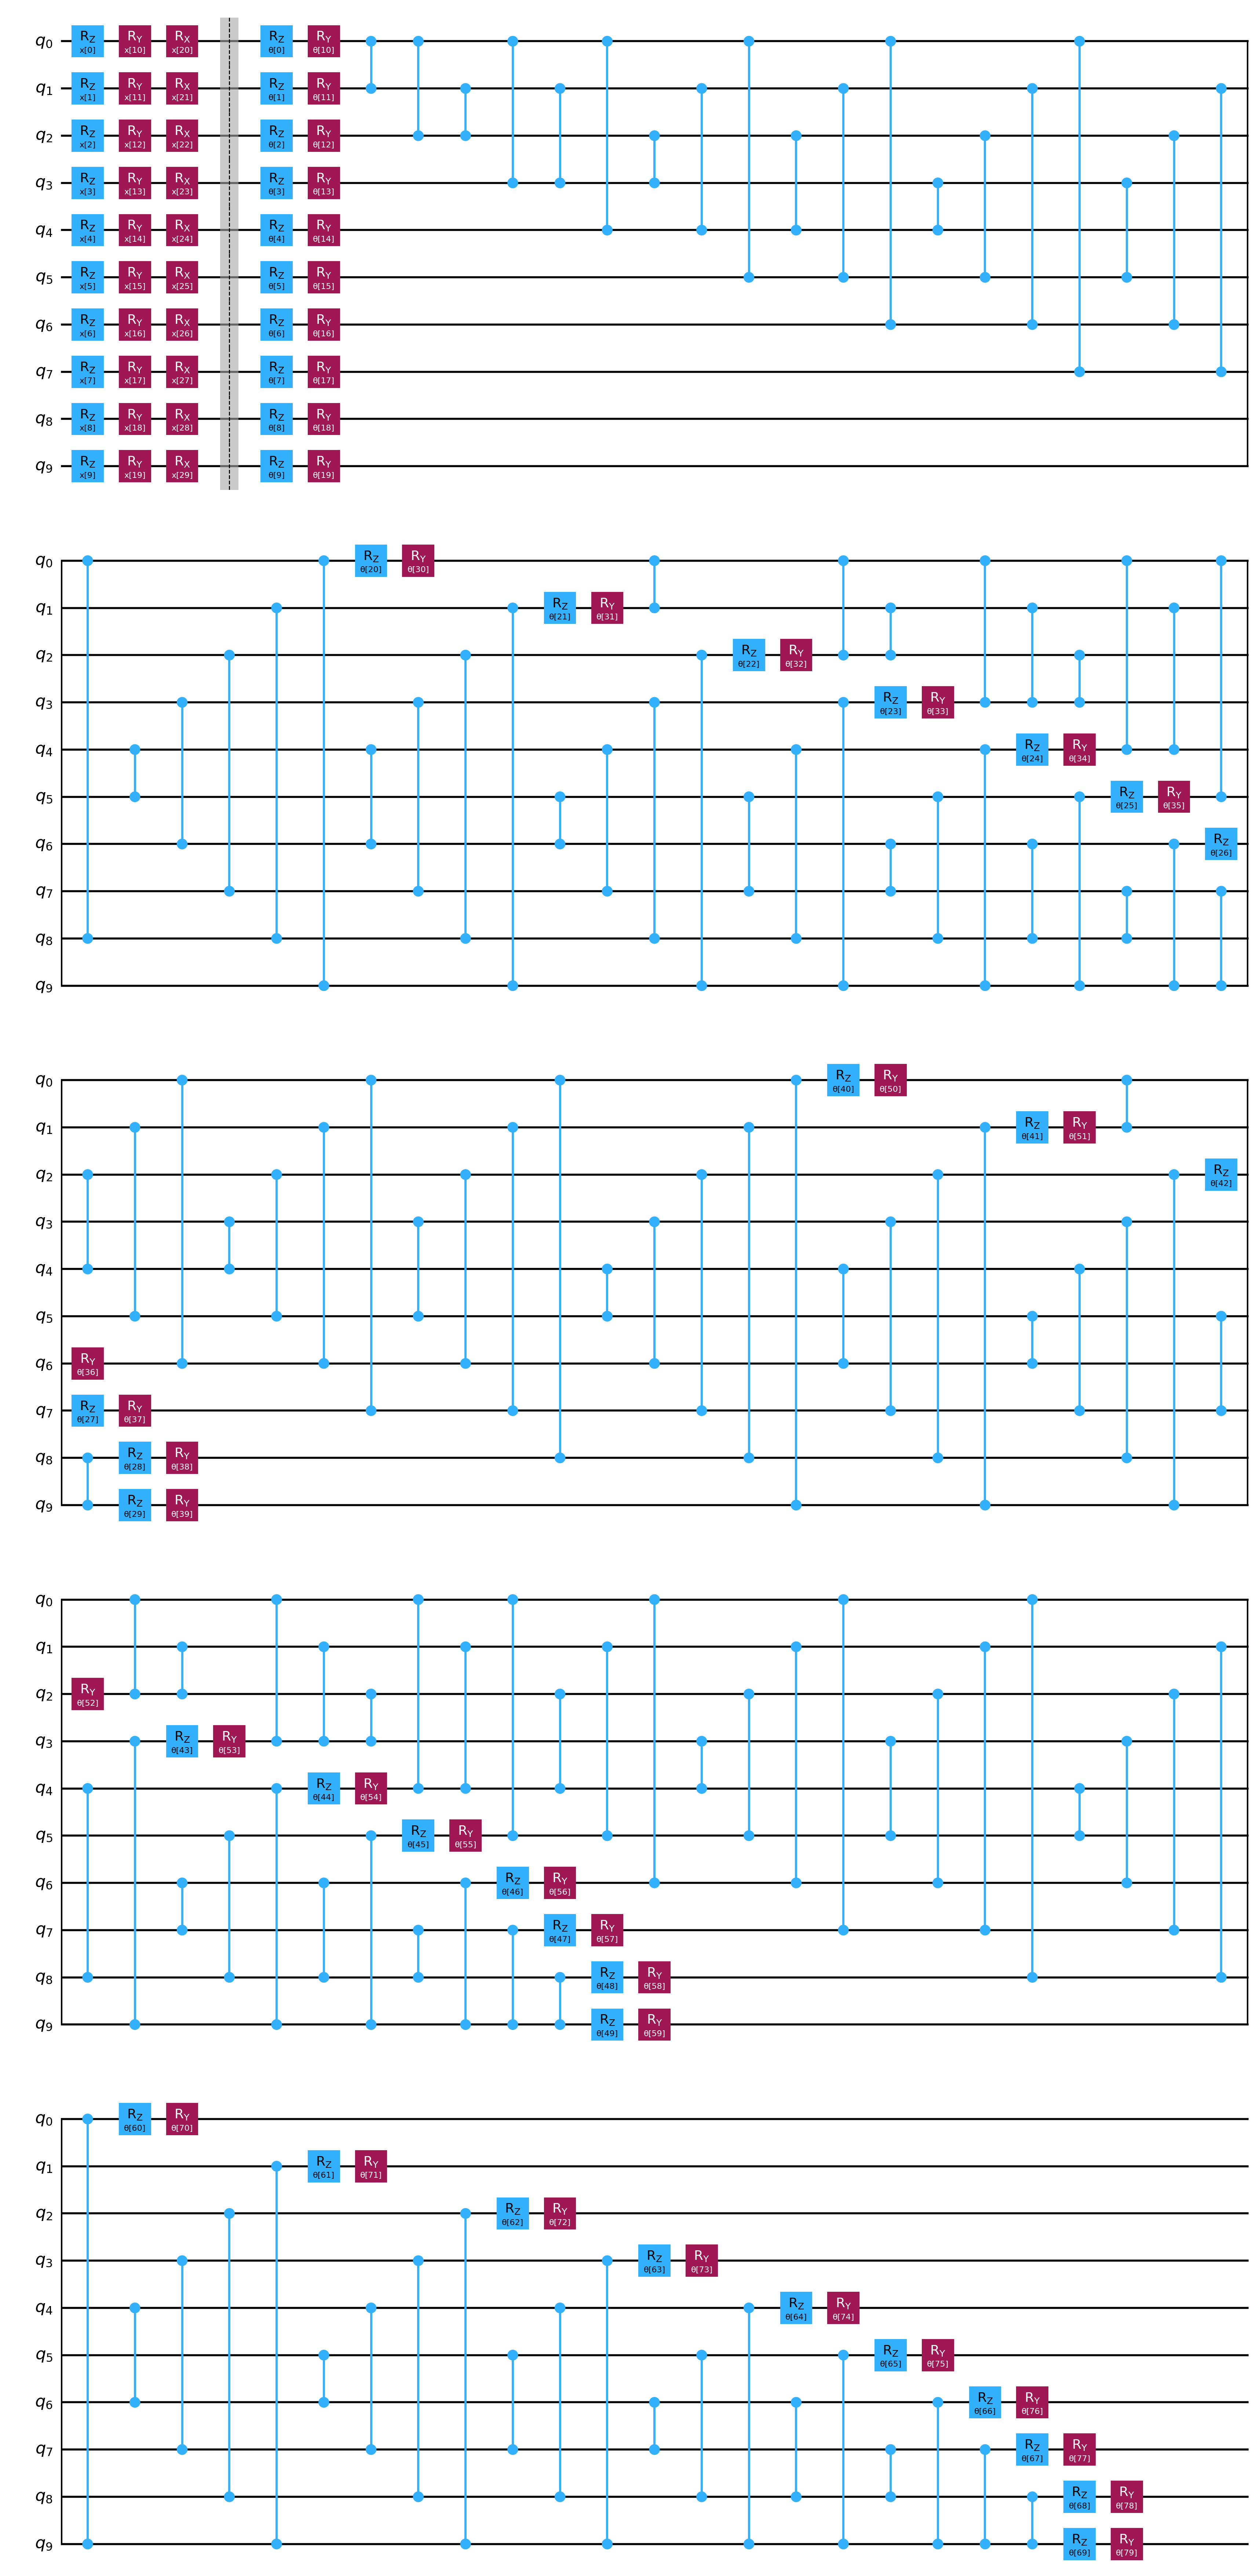

In [17]:
num_qubits = X.shape[1] // 3
featuremap = EfficientSU2(num_qubits=num_qubits, reps=0, parameter_prefix='x',
                          su2_gates=['rz', 'ry', 'rx'])
ansatz = TwoLocal(num_qubits=num_qubits, reps=3, entanglement_blocks='cz', rotation_blocks=['rz', 'ry'])
qc = QuantumCircuit(num_qubits)

qc.compose(featuremap, inplace=True)
qc.barrier()
qc.compose(ansatz, inplace=True)
qc.decompose().draw(output='mpl', scale=2, style='iqx')

# **Classical Tests**

In [ ]:
from keras import Sequential
from keras.layers import Dense

In [ ]:
breast_cancer= load_breast_cancer()

X, Y = breast_cancer['data'], breast_cancer['target']

X_scaled = MinMaxScaler().fit_transform(X)



In [ ]:
input_shape = X.shape[1]

In [ ]:
model = Sequential()
model.add(Dense(input_shape, activation='relu', input_shape=(input_shape,)))
model.add(Dense(input_shape, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

In [ ]:
model.fit(X_train, Y_train, verbose=1, epochs=50, validation_split=0.2)

Epoch 1/50
12/12 [==============================] - 2s 40ms/step - loss: 0.6769 - accuracy: 0.6566 - val_loss: 0.6464 - val_accuracy: 0.8681
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 0.6360 - accuracy: 0.8324 - val_loss: 0.6037 - val_accuracy: 0.8791
Epoch 3/50
12/12 [==============================] - 0s 9ms/step - loss: 0.5916 - accuracy: 0.8544 - val_loss: 0.5551 - val_accuracy: 0.8681
Epoch 4/50
12/12 [==============================] - 0s 8ms/step - loss: 0.5387 - accuracy: 0.8874 - val_loss: 0.4996 - val_accuracy: 0.8681
Epoch 5/50
12/12 [==============================] - 0s 8ms/step - loss: 0.4796 - accuracy: 0.8846 - val_loss: 0.4423 - val_accuracy: 0.8681
Epoch 6/50
12/12 [==============================] - 0s 9ms/step - loss: 0.4149 - accuracy: 0.9203 - val_loss: 0.3823 - val_accuracy: 0.8681
Epoch 7/50
12/12 [==============================] - 0s 9ms/step - loss: 0.3513 - accuracy: 0.9286 - val_loss: 0.3284 - val_accuracy: 0.8791
Epoch 8/50
12/12 [=

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

4/4 [==============================] - 0s 12ms/step - loss: 0.0776 - accuracy: 0.9649


In [ ]:
accs = [accuracy]

In [ ]:
for i in range(4):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, random_state=42, test_size=0.2)

  model = Sequential()
  model.add(Dense(input_shape, activation='relu', input_shape=(input_shape,)))
  model.add(Dense(input_shape, activation='relu'))
  model.add(Dense(2, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.fit(X_train, Y_train, verbose=1, epochs=50, validation_split=0.2)

  loss, accuracy = model.evaluate(X_test, Y_test)

  accs.append(accuracy)
  print(accs)

Epoch 1/50
12/12 [==============================] - 3s 38ms/step - loss: 0.6657 - accuracy: 0.7885 - val_loss: 0.6398 - val_accuracy: 0.8022
Epoch 2/50
12/12 [==============================] - 0s 11ms/step - loss: 0.6217 - accuracy: 0.8819 - val_loss: 0.5978 - val_accuracy: 0.9121
Epoch 3/50
12/12 [==============================] - 0s 10ms/step - loss: 0.5783 - accuracy: 0.8929 - val_loss: 0.5520 - val_accuracy: 0.8681
Epoch 4/50
12/12 [==============================] - 0s 9ms/step - loss: 0.5305 - accuracy: 0.9011 - val_loss: 0.5020 - val_accuracy: 0.9011
Epoch 5/50
12/12 [==============================] - 0s 10ms/step - loss: 0.4783 - accuracy: 0.9038 - val_loss: 0.4476 - val_accuracy: 0.9011
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 0.4225 - accuracy: 0.9038 - val_loss: 0.3942 - val_accuracy: 0.8901
Epoch 7/50
12/12 [==============================] - 0s 9ms/step - loss: 0.3614 - accuracy: 0.9148 - val_loss: 0.3407 - val_accuracy: 0.8901
Epoch 8/50
12/12

**Accuracy:**
1. 0.9649122953414917
2. 0.9824561476707458
3. 0.9736841917037964
4. 0.9824561476707458
5. 0.9736841917037964
